<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagation analysis of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using linguistic distance as a means to seek for possible routes the Greek proverbs may have travelled spatially.
---


In [1]:
%%capture
!pip install python-Levenshtein
import pandas as pd
from Levenshtein import distance as lev
import numpy as np
import seaborn as sns
import networkx as nx

In [2]:
import os
# not sharing the machine actionable dataset shared in full w/o explicit consent  
if not os.path.exists('proverbs.csv'):
    proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
    proverbs.to_csv('proverbs.csv', index=False)
else:
    proverbs = pd.read_csv('proverbs.csv')

# the duplicates, geolocated in this study
duplicates = pd.read_pickle('https://github.com/ipavlopoulos/paremia/raw/main/input/duplicates_geolocated.csv')
geolocs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/geolocs.csv")

In [3]:
# basic processing
proverbs = proverbs[proverbs.collector!="anonymous"]
geolocs.index=["lat", "lon"]
geolocs = geolocs.to_dict()

In [4]:
# adding lat/lon/area information
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs = proverbs[proverbs.lon.notna()&proverbs.lat.notna()]

## Proverb spatial propagation

* Besides (text-) duplicates, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* Using linguistic distance, we can estimate the route of a proverb, assuming that shorter travels lead to fewer edits.

In [5]:
highly_distr = duplicates.sort_values(by='area_num', ascending=False).head(3)

In [6]:
highly_distr

,place,place_num,area,area_num,latlon
text,,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Ήπειρος, Δρόβιανη, Αρκαδία, Δημητσάνα, Μικρά ...",45,"{Εύβοια, Ικαρία, Κοζάνη, Θεσπρωτία, Ιωάννινα, ...",23,"[(37.599929450000005, 26.151689404867284), (35..."
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Κρήτη, Ρέθυμνο, Μαλλάκι, Κοζάνη, Κοντοβούνι, ...",26,"{Ικαρία, Κοζάνη, Θεσπρωτία, Ιωάννινα, Κρήτη, Π...",20,"[(37.599929450000005, 26.151689404867284), (35..."
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Ήπειρος, Δρόβιανη, Θράκη, Σηλυβρία, Νάξος, Απ...",28,"{Αδριανούπολη, Εύβοια, Χίος, Αρκαδία, Αμοργός,...",18,"[(37.9982534, 23.7378671), (37.06001045, 25.47..."


* Measuring the edit distance between each of this and all other (non-duplicate) proverbs

In [7]:
#@title Source (finding indirect paths)
#@markdown Assumption: the shortest linguistic path reveals the propagation

def find_near_duplicates(text, candidate_texts, candidate_areas, max_edits=5):
    distances = [lev(x, target) for x in candidate_texts]
    candidates = pd.DataFrame({'text':candidate_texts, 'lev': distances, 'area': candidate_areas})
    near_duplicates = candidates[(candidates.lev<max_edits)&((candidates.lev>0))]
    near_duplicates = near_duplicates.sort_values("lev", ascending=False)
    return near_duplicates

# Check that a list has no two consecutive duplicates.
# That will be used later on to ensure that we do not
# move from a place to the same place.
def has_no_consecutive_duplicates(lst):
    for a, b in zip(lst, lst[1:]):
        if a == b:
            return False
    return True

# Calculate direct distances matrix.

def find_indirect_paths(near_duplicates, verbose=0):
    n = len(near_duplicates)
    direct_dist_matrix = np.zeros((n, n))

    for u in range(n):
        for v in range(n):
            direct_dist_matrix[u, v] = lev(near_duplicates['text'].iloc[u], near_duplicates['text'].iloc[v])

    # Now calculate shortest paths, not necessarily direct.

    dist_matrix = np.zeros((n, n))
    G = nx.from_numpy_array(direct_dist_matrix, parallel_edges=False, create_using=nx.Graph)

    shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
    indirect_shortest_paths = {}
    num_indirect_shortest_paths = 0
    for u in range(n):
        for v in range(n):
            u_v_shortest_paths = nx.all_shortest_paths(G, u, v, weight='weight')
            for path in u_v_shortest_paths:
                if len(path) > 2:
                    if u not in indirect_shortest_paths:
                        indirect_shortest_paths[u] = { }
                    if v not in indirect_shortest_paths[u]:
                        indirect_shortest_paths[u][v] = []
                    indirect_shortest_paths[u][v].append(path)
                    num_indirect_shortest_paths += 1
            if direct_dist_matrix[u][v] != 0:
                dist_matrix[u][v] = shortest_path_lengths[u][v]

    for u, v_paths in indirect_shortest_paths.items():
        out = []
        clean_pahts = []
        for v, paths in v_paths.items():
            decoded_paths = [ 
                [near_duplicates['area'].iloc[node] for node in path] 
                for path in paths
            ]
            proverb_paths = [
                [near_duplicates['text'].iloc[node] for node in path] 
                for path in paths
            ]
            if verbose > 0:
                print(f'shortest indirect paths {u}->{v}:')
                print(f'{paths}: {decoded_paths}')
            non_trivial_paths = []
            non_trivial_decoded_paths = []
            non_trival_proverb_paths = []
            for (p, dp, pp) in zip(paths, decoded_paths, proverb_paths):
                if has_no_consecutive_duplicates(dp) and dp[0] != dp[-1]:
                    non_trivial_paths.append(p)
                    non_trivial_decoded_paths.append(dp)
                    non_trival_proverb_paths.append(pp)
            if verbose > 0:
                print('shortest non trivial paths')
            if len(non_trivial_decoded_paths) > 0:
                out.extend([(dp, non_trival_proverb_paths[i])
                            for i, dp in enumerate(non_trivial_decoded_paths)])
                if verbose > 0:
                    print(non_trivial_paths)
                    print(non_trivial_decoded_paths)
                    print(non_trival_proverb_paths)
                    print('---')
            else:
                if verbose > 0:
                    print('None')
        return out

In [8]:
#@title Use case: ''The tongue doesn't have bones, yet bones it crashes''

i = 0

target = highly_distr.reset_index().iloc[i].text
print(target)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values)
new_areas = set(ndups.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)

find_indirect_paths(ndups)

Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει
6
{'Νάουσα', 'Σκύρος', 'Αδριανούπολη', 'Ρόδος', 'Μακεδονία', 'Κως'}


[(['Κύπρος', 'Μακεδονία', 'Θράκη'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει",
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'"]),
 (['Κύπρος', 'Ρούμελη', 'Νάουσα'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   'Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει"]),
 (['Κύπρος', 'Μακεδονία', 'Νάουσα'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει",
   "Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει"]),
 (['Κύπρος', 'Μακεδονία', 'Θράκη'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει",
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'"]),
 (['Κύπρος', 'Ρούμελη', 'Κοζάνη'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   'Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζ'ει"])]

### Alternative: Agglomerative clustering

```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Fetching versions up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [9]:
target = highly_distr.reset_index().iloc[0].text
print(target)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values)

Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει


In [10]:
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
areas = ndups.area.apply(lambda a: loc_name[a]).values

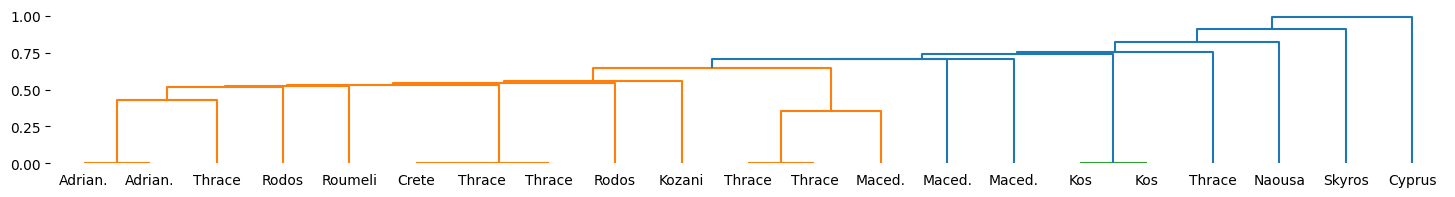

In [11]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(ndups.text.values)
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(18, 2))
ax = dendrogram(Z, orientation='top', labels=areas, distance_sort='descending', show_leaf_counts=False, leaf_font_size=10., show_contracted=True, leaf_rotation=0);
sns.despine(left=True, bottom=True);
fig.savefig('tongue.pdf', format="PDF", dpi=300)

In [12]:
clustering = fcluster(Z, t=0.4, criterion='distance')
ndups.insert(3, "clustering", clustering)
grouped = ndups.groupby("clustering")
clusters = pd.DataFrame({"cluster":grouped.area.apply(list), "text":grouped.text.apply(list)})
clusters[clusters.cluster.apply(len)>1]

,cluster,text
clustering,,
1,"[Κως, Κως]",[Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακί...
2,"[Θράκη, Θράκη, Μακεδονία]","[Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ',..."
3,"[Θράκη, Κρήτη, Θράκη]","[Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί,..."
4,"[Αδριανούπολη, Αδριανούπολη]","[Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,..."


In [13]:
# focus on clusters with more than one area
for i, row in clusters[clusters.cluster.apply(len)>1].iterrows():
    # hash to avoid duplicated areas (neighbouring proverbs)
    d = dict(list(zip(row.cluster, row.text)))
    if len(d)>1: # ignore duplicates
        # print the clustered versions  
        for place in d:
            print(f'{place} --> {d[place]}')
        print()

Θράκη --> Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'
Μακεδονία --> Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει

Θράκη --> Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί
Κρήτη --> Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί



## Two more use cases

In [ ]:
#@title ''Knocking on a deaf man's door''

i = 1

target = highly_distr.reset_index().iloc[i].text
print(target)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values)
new_areas = set(ndups.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas)); print(new_areas)

find_indirect_paths(ndups)

Στου κουφού την πόρτα όσο θέλεις βρόντα
19
{'Εύβοια', 'Κέρκυρα', 'Μακεδονία', 'Χίος', 'Σάμος', 'Αχαΐα', 'Κορινθία', 'Αργολίδα', 'Μικρά Ασία', 'Δαρδανέλλια (Ελλήσποντος)', 'Μήλος', 'Ήπειρος', 'Αδριανούπολη', 'Κάρπαθος', 'Κως', 'Ρόδος', 'Ηλεία', 'Κύπρος', 'Λέσβος'}


In [15]:
#@title ''Easy come easy go''

i = 2

target = highly_distr.reset_index().iloc[i].text
print(target)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values, 3)
new_areas = set(ndups.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas)); print(new_areas)

find_indirect_paths(ndups)

Ανεμομαζώματα, διαβολοσκορπίσματα
12
{'Θεσπρωτία', 'Αιτωλοακαρνανία', 'Ρούμελη', 'Κεφαλληνία', 'Ανατολική Θράκη', 'Βοιωτία', 'Λακωνία', 'Επτάνησος', 'Κύπρος', 'Θεσσαλία', 'Φιλιππούπολη', 'Ημαθία'}


[(['Βοιωτία', 'Ημαθία', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Θράκη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Κρήτη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Μικρά Ασία', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Ανατολική Θράκη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Ρούμελη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Μικρά Ασία', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολ